['AllFile', 'SPK01', 'SPK01_ind', 'SPK01_ts', 'SPK01_ts_step', 'SPK01a', 'SPK01a_wf', 'SPK01a_wf_ts', 'SPK01b', 'SPK01b_wf', 'SPK01b_wf_ts', 'Start', 'Stop']
raw_signal: n=4799950, mean=8.92e-06, std=13.1, min=-215, max=183


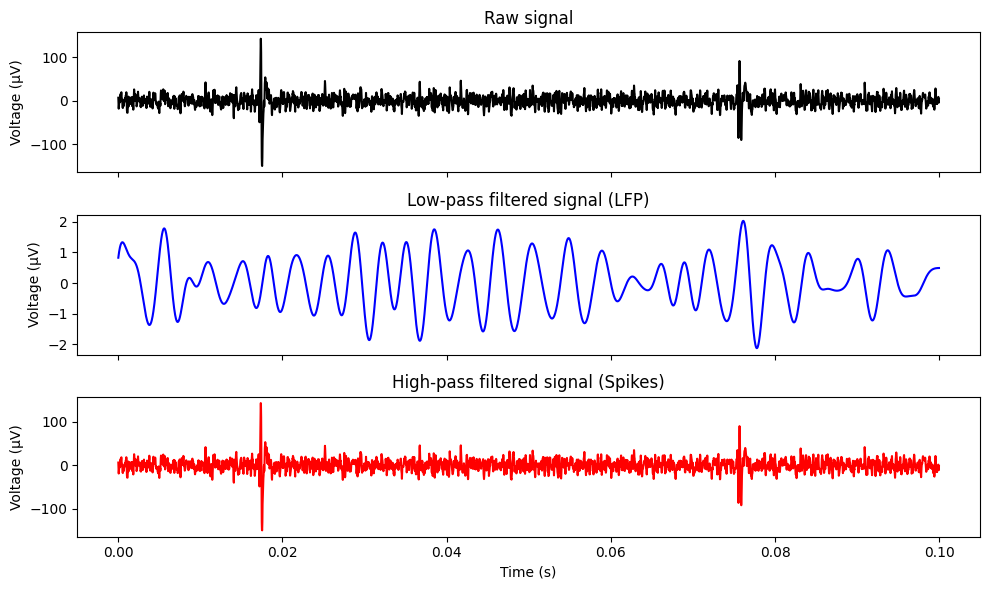

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


def plotSignal(raw_signal, t_start=0.0, t_duration=0.1):
    """
    Plot raw, low-pass, and high-pass filtered extracellular signal.
    Accepts the raw signal vector.

    Assumes extracellular sampling rate ~40 kHz.
    """
    
    # fixed sampling rate 
    fs = 40000.0  # Hz
    nyq = fs / 2

    raw_signal = np.asarray(raw_signal, dtype=float).squeeze()
    raw_signal *= 1e3  # convert to microvolts

    # print signal stats
    print(f"raw_signal: n={raw_signal.size}, mean={raw_signal.mean():.3g}, std={raw_signal.std():.3g}, "
          f"min={raw_signal.min():.3g}, max={raw_signal.max():.3g}")

    # select time segment (by samples) 
    start_idx = int(round(t_start * fs))
    end_idx   = int(round((t_start + t_duration) * fs))
    end_idx = min(end_idx, raw_signal.size)

    sig = raw_signal[start_idx:end_idx]

    # time axis should reflect absolute time window
    t = (np.arange(sig.size) / fs) + t_start

    # filter parameters 
    cutoff = 300.0  # Hz
    order = 4

    # Lowpass (LFP)
    b_lp, a_lp = butter(order, cutoff / nyq, btype="low")
    sig_low = filtfilt(b_lp, a_lp, sig)

    # Highpass (Spikes)
    b_hp, a_hp = butter(order, cutoff / nyq, btype="high")
    sig_high = filtfilt(b_hp, a_hp, sig)

    # Plot 
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    axes[0].plot(t, sig, color="black")
    axes[0].set_title("Raw signal")
    axes[0].set_ylabel("Voltage (µV)")

    axes[1].plot(t, sig_low, color="blue")
    axes[1].set_title("Low-pass filtered signal (LFP)")
    axes[1].set_ylabel("Voltage (µV)")

    axes[2].plot(t, sig_high, color="red")
    axes[2].set_title("High-pass filtered signal (Spikes)")
    axes[2].set_ylabel("Voltage (µV)")
    axes[2].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()
    
import scipy.io as sio

# Load .mat file
mat_path = r"/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Neurobiology lab/lab 5 - neural decoding/matlab results/Ch01 walk daniil.mat"
mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

# List variable names in the .mat file
print([k for k in mat.keys() if not k.startswith("__")])

# Extract raw signal from SPK01 variable and plot
spk01 = mat["SPK01"]
raw = spk01[:, 0]  
plotSignal(raw, t_start=0.0, t_duration=0.1)

The raw extracellular signal contains a mixture of slow fluctuations, fast transients, and background noise. In the unfiltered trace, action potentials appear as brief, high-amplitude deflections embedded within lower-amplitude, slower variations, making it difficult to isolate specific components of neural activity.

Applying a low-pass filter preserves the slow components of the signal while attenuating rapid voltage changes. As a result, sharp spike waveforms are removed and the signal becomes dominated by smooth, oscillatory fluctuations corresponding to local field potentials (LFPs), which reflect the summed synaptic and dendritic activity of nearby neuronal populations.

In contrast, applying a high-pass filter removes the slow fluctuations and emphasizes fast transients. This filtering isolates the brief, high-frequency components associated with action potentials, allowing individual spikes to be clearly distinguished from the background signal.

Overall, filtering decomposes the original raw signal into functionally distinct components: low-frequency activity related to population-level synaptic dynamics and high-frequency activity corresponding to single-neuron spiking.

The reason we do not see major differences between the high-pass filtered signal and the raw signal is that extracellular recordings are inherently dominated by high-frequency components. The recording configuration and acquisition system already attenuate very slow fluctuations and DC offsets, such that the raw signal contains relatively little low-frequency content to begin with. Consequently, applying a high-pass filter removes only a small residual slow component, leaving the overall waveform largely unchanged. Under these conditions, the high-pass filter primarily serves to slightly sharpen spike waveforms rather than to dramatically alter the signal, which explains the strong visual similarity between the raw and high-pass filtered traces.

['ch01Stand', 'ch01Walk', 'ch13Stand', 'ch13Walk', 'ch20Stand', 'ch20Walk']


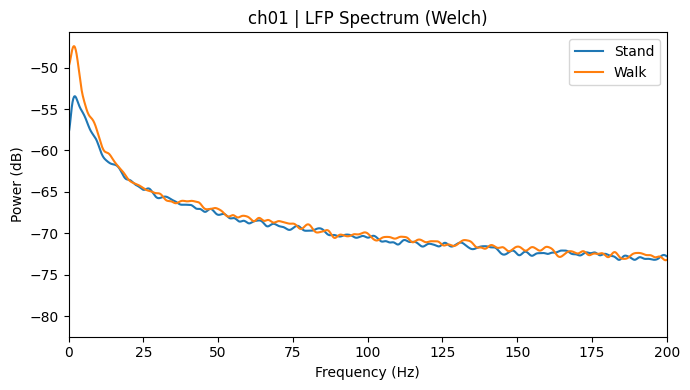

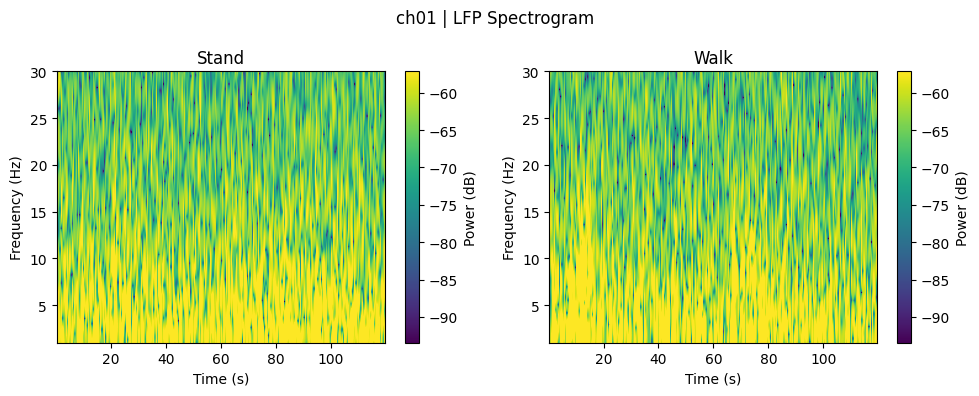

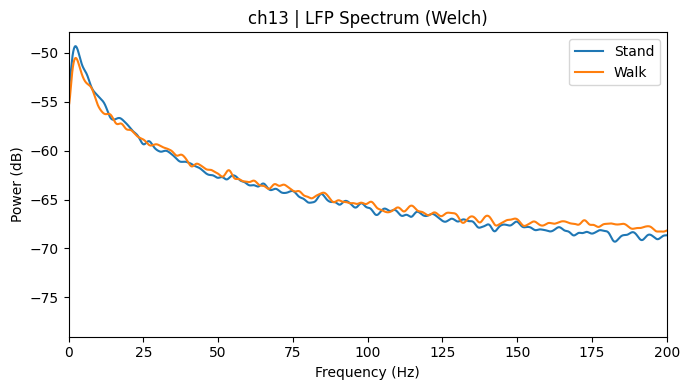

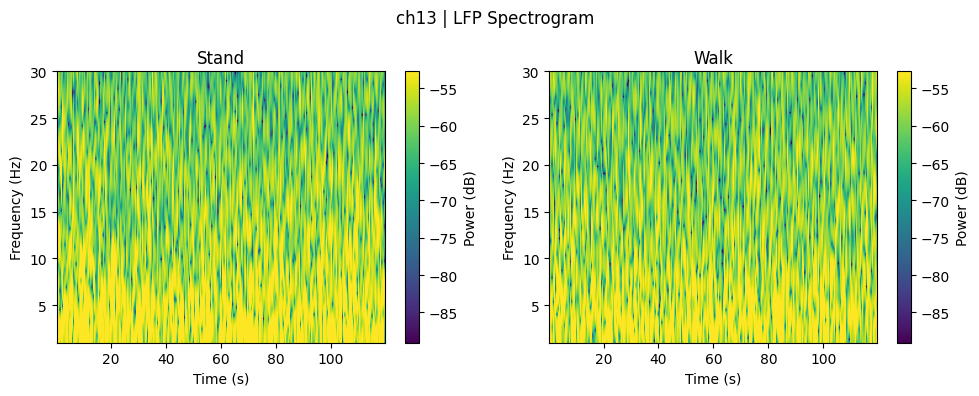

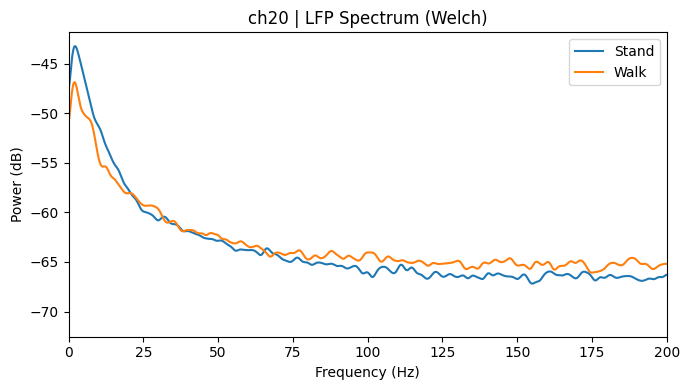

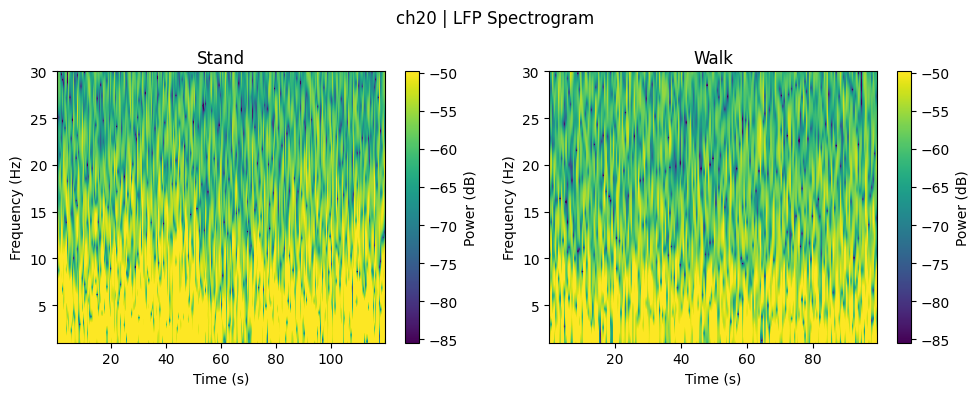

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal


def LFP_spectrum(lfp_data, Fs):
    """
    LFP spectral analysis according to protocol.
    Shows absolute PSD in dB.
    Compares Stand vs Walk for ch01, ch13, ch20.
    """

    # ---- protocol parameters ----
    NFFT = 8192
    window = signal.get_window("hann", 600)
    overlap = int(len(window) * 0.25)

    channels = [1, 13, 20]

    for ch in channels:
        stand_key = f"ch{ch:02d}Stand"
        walk_key  = f"ch{ch:02d}Walk"

        stand = np.asarray(lfp_data[stand_key], dtype=float).squeeze()
        walk  = np.asarray(lfp_data[walk_key],  dtype=float).squeeze()

        # ================= Spectrum (Welch) =================
        fS, pS = signal.welch(
            stand, fs=Fs, window=window,
            nperseg=len(window), noverlap=overlap, nfft=NFFT
        )
        fW, pW = signal.welch(
            walk, fs=Fs, window=window,
            nperseg=len(window), noverlap=overlap, nfft=NFFT
        )

        plt.figure(figsize=(7, 4))
        plt.plot(fS, 10*np.log10(pS + 1e-20), label="Stand")
        plt.plot(fW, 10*np.log10(pW + 1e-20), label="Walk")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power (dB)")
        plt.title(f"ch{ch:02d} | LFP Spectrum (Welch)")
        plt.xlim(0, 200)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ================= Spectrogram =================
        f, tS, specS = signal.spectrogram(
            stand, fs=Fs, window=window,
            nperseg=len(window), noverlap=overlap,
            nfft=NFFT, scaling="density", mode="psd"
        )
        _, tW, specW = signal.spectrogram(
            walk, fs=Fs, window=window,
            nperseg=len(window), noverlap=overlap,
            nfft=NFFT, scaling="density", mode="psd"
        )

        # absolute PSD in dB 
        specS_db = 10 * np.log10(specS + 1e-20)
        specW_db = 10 * np.log10(specW + 1e-20)

        # color scale 
        all_vals = np.concatenate([specS_db.ravel(), specW_db.ravel()])
        vmin = np.percentile(all_vals, 1)
        vmax = np.percentile(all_vals, 99)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(
            specS_db, aspect="auto", origin="lower",
            extent=[tS.min(), tS.max(), f.min(), f.max()],
            vmin=vmin, vmax=vmax
        )
        plt.ylim(1, 30)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Stand")
        plt.colorbar(label="Power (dB)")

        plt.subplot(1, 2, 2)
        plt.imshow(
            specW_db, aspect="auto", origin="lower",
            extent=[tW.min(), tW.max(), f.min(), f.max()],
            vmin=vmin, vmax=vmax
        )
        plt.ylim(1, 30)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Walk")
        plt.colorbar(label="Power (dB)")

        plt.suptitle(f"ch{ch:02d} | LFP Spectrogram")
        plt.tight_layout()
        plt.show()

import scipy.io as sio

# load LFP data
lfp_path = r"/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Neurobiology lab/lab 5 - neural decoding/matlab results/LFP_data.mat"
lfp_data = sio.loadmat(lfp_path, squeeze_me=True, struct_as_record=False)
print([k for k in lfp_data.keys() if not k.startswith("__")])

# run LFP spectral analysis
LFP_spectrum(lfp_data, Fs=1000.0)

Across the three channels, the comparison between Stand and Walk reveals clear but channel-specific spectral modulations rather than a uniform global effect. In ch01, the Walk condition is characterized by a relative enhancement of low-frequency power, visible as a systematic elevation of the spectrum at the lowest frequencies and a generally steeper spectral decay, suggesting increased dominance of slow LFP fluctuations during movement. In contrast, ch13 shows largely overlapping spectra between the two conditions, with only minor broadband deviations and no pronounced redistribution of power across frequencies, indicating minimal sensitivity to the behavioral state. A different pattern emerges in ch20, where the Walk condition exhibits a relative reduction in low-frequency power accompanied by a subtle but consistent elevation at higher frequencies, producing a flatter overall spectral profile. Together, these results indicate that walking induces heterogeneous, channel-dependent changes in LFP dynamics, ranging from low-frequency enhancement to desynchronization-like spectral flattening, rather than a single uniform spectral shift across recording sites.